# **Desafio Previsão de Evasão - Telecom X**

Este notebook dá continuidade ao desafio proposto pela Alura, com foco na construção de modelos preditivos para antecipar a evasão de clientes da empresa fictícia Telecom X.

Aqui, a proposta é preparar os dados tratados na etapa anterior, aplicar técnicas de pré-processamento, treinar e avaliar modelos de classificação para identificar quais clientes têm maior risco de cancelar seus serviços.

O objetivo é gerar um pipeline de machine learning que possibilite à empresa agir preventivamente, reduzindo o churn com base em previsões confiáveis.

---

**O que será feito aqui:**

- Preparação final dos dados para modelagem (encoding, normalização)
- Seleção e engenharia de variáveis relevantes
- Treinamento de múltiplos modelos de classificação
- Avaliação dos modelos com métricas adequadas
- Interpretação dos resultados e identificação dos principais fatores de churn

In [626]:
# Bibliotecas

# Tipagem
from typing import Any, Union, Optional, Tuple, Dict
from collections.abc import Callable

# Utilitários
from pathlib import Path

# Conexão com API
import requests

# Manipulação de Dados
import pandas as pd
import numpy as np
import json

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Estatística
from scipy.stats import pointbiserialr
from scipy.stats.contingency import chi2_contingency, association

# Sklearn

# Base
from sklearn.base import ClassifierMixin

# Pré-processamento
# Encoding
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    TargetEncoder,
    OrdinalEncoder,
)

# Scaling
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler
)

# Imputação
from sklearn.impute import (
    SimpleImputer
)
# Split de Dados
from sklearn.model_selection import train_test_split

# Pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Cross Validation
from sklearn.model_selection import (
    cross_validate
)

# Estratégia de fold
from sklearn.model_selection import StratifiedKFold

# Seleção de Features
from sklearn.feature_selection import mutual_info_classif

# Modelos
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Métricas
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
)

# Visualizações do sklearn
from sklearn.metrics import(
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay
)

# Interpretação de modelos
from eli5 import show_weights
from eli5.sklearn import PermutationImportance

In [627]:
# Configurações globais Seaborn
sns.set_theme(
    style='white', # Estilo do gráfico
    font='sans-serif', # Fonte do texto
    font_scale=1.1 # Escala da fonte
)

In [628]:
# Obtém o diretório do projeto
current_dir = Path.cwd().parent

# Define o caminho do diretório de dados externos
external_data_dir = current_dir / 'data' / 'external'

# Define o caminho do diretório de dados processados
processed_data_dir = current_dir / 'data' / 'processed'

# Define o caminho do diretório de visualizações
plots_dir = current_dir / 'visualizations'

## **Importação dos dados processados**

Como os dados já foram tratados no notebook anterior, vamos importar os dados processados diretamente para este notebook. 

In [629]:
# Url do dataset
dataset_url = 'https://raw.githubusercontent.com/jvsobrinho/challenge2-data-science/refs/heads/main/data/processed/telecomx_cleanned.csv'

In [630]:
# Carrega o dataset
telecom_processed = pd.read_csv(dataset_url)

In [631]:
# Exibe as informações do DataFrame
telecom_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7043 non-null   object 
 1   Churn                      7043 non-null   object 
 2   customer_gender            7043 non-null   object 
 3   customer_SeniorCitizen     7043 non-null   int64  
 4   customer_Partner           7043 non-null   object 
 5   customer_Dependents        7043 non-null   object 
 6   customer_tenure            7043 non-null   int64  
 7   phone_PhoneService         7043 non-null   object 
 8   phone_MultipleLines        7043 non-null   object 
 9   internet_InternetService   7043 non-null   object 
 10  internet_OnlineSecurity    7043 non-null   object 
 11  internet_OnlineBackup      7043 non-null   object 
 12  internet_DeviceProtection  7043 non-null   object 
 13  internet_TechSupport       7043 non-null   objec

Os dados já foram tratados, mas como foram salvos em formato CSV, ao importá-los, o pandas irá inferir os tipos de dados.
Precisamos modificar os tipos dos dados com base no que foi feito no notebook anterior.

In [632]:
# Dicionário de tipos de dados
col_types = {
    "customerID": "string",
    "Churn": "category",
    "customer_gender": "category",
    "customer_SeniorCitizen": "category",
    "customer_Partner": "category",
    "customer_Dependents": "category",
    "customer_tenure": "int64",
    "phone_PhoneService": "category",
    "phone_MultipleLines": "category",
    "internet_InternetService": "category",
    "internet_OnlineSecurity": "category",
    "internet_OnlineBackup": "category",
    "internet_DeviceProtection": "category",
    "internet_TechSupport": "category",
    "internet_StreamingTV": "category",
    "internet_StreamingMovies": "category",
    "account_Contract": "category",
    "account_PaperlessBilling": "category",
    "account_PaymentMethod": "category",
    "account_Charges_Monthly": "float64",
    "account_Charges_Total": "float64"
}

# Ler o dataset novamente com os tipos de dados especificados
telecom_processed = pd.read_csv(dataset_url, dtype=col_types)

# Verifica os tipos de dados
telecom_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   customerID                 7043 non-null   string  
 1   Churn                      7043 non-null   category
 2   customer_gender            7043 non-null   category
 3   customer_SeniorCitizen     7043 non-null   category
 4   customer_Partner           7043 non-null   category
 5   customer_Dependents        7043 non-null   category
 6   customer_tenure            7043 non-null   int64   
 7   phone_PhoneService         7043 non-null   category
 8   phone_MultipleLines        7043 non-null   category
 9   internet_InternetService   7043 non-null   category
 10  internet_OnlineSecurity    7043 non-null   category
 11  internet_OnlineBackup      7043 non-null   category
 12  internet_DeviceProtection  7043 non-null   category
 13  internet_TechSupport       7043 n

In [633]:
telecom_processed.head()

,customerID,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,...,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges_Monthly,account_Charges_Total,daily_charges
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,2.19
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,2.00
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,2.46
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,3.27
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40,2.80


Agora temos os dados carregados e com os tipos corretos, prontos para a próxima etapa de encoding.

## **Preparação dos dados**

### **Criando uma feature de contagem**

Vamos criar uma feature que conta o número de serviços de internet adicionados por cada cliente. Essa feature pode ser útil para identificar clientes que possuem múltiplos serviços e, portanto, podem ter um comportamento diferente em relação à evasão.

In [634]:
# Lista de variáveis que começam com 'internet_'
# excluindo 'internet_InternetService'
internet_vars = [
    col for col in telecom_processed.columns 
    if col.startswith('internet_') and col != 'internet_InternetService'
]

internet_vars

['internet_OnlineSecurity',
 'internet_OnlineBackup',
 'internet_DeviceProtection',
 'internet_TechSupport',
 'internet_StreamingTV',
 'internet_StreamingMovies']

In [635]:
# Cria uma variável que conta o número de serviços de internet contratados
# Soma 1 para cada 'Yes'
telecom_processed['internet_num_services'] = telecom_processed[internet_vars].apply(
    lambda row: row.str.contains('Yes').sum(), axis=1
)

In [636]:
telecom_processed[internet_vars + ['internet_num_services']].head()

,internet_OnlineSecurity,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,internet_num_services
0,No,Yes,No,Yes,Yes,No,3
1,No,No,No,No,No,Yes,1
2,No,No,Yes,No,No,No,1
3,No,Yes,Yes,No,Yes,Yes,4
4,No,No,No,Yes,Yes,No,2


### **Removendo colunas desnecessárias**

Em um cenário de produção, o `customerID` é utilizado exclusivamente para rastreamento e auditoria, sendo armazenado em logs ou sistemas de monitoramento, mas **não participa** do pipeline de machine learning. Neste notebook, simulamos esse comportamento removendo a coluna do DataFrame.

In [637]:
# Remove a coluna 'customerID' do DataFrame, com inplace=True
# para não precisar reatribuir o DataFrame
telecom_processed.drop(columns=['customerID'], axis=1, inplace=True)

### **Proporção de classes da variável alvo**

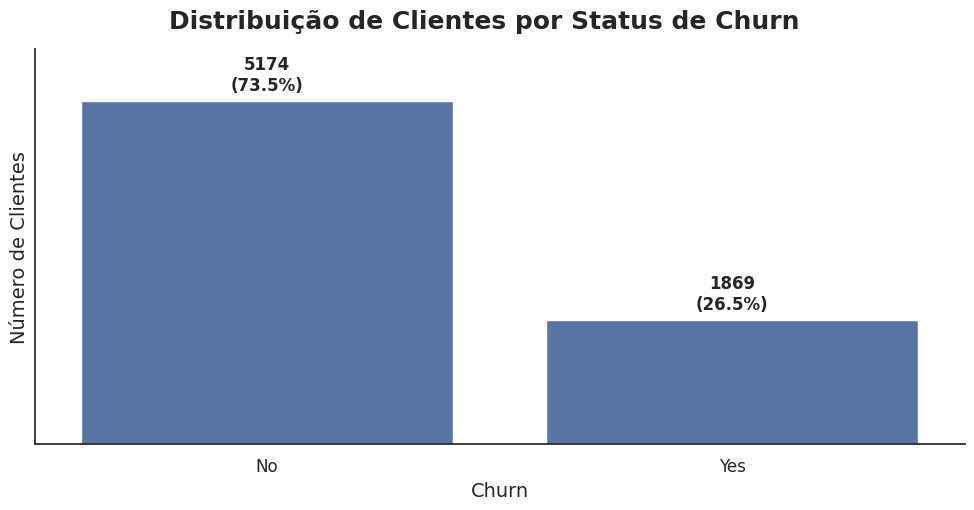

In [638]:
# Cria a figura e o eixo
fig, ax = plt.subplots(figsize=(12, 5))

# Ajusta espaço superior para o suptitle
fig.subplots_adjust(top=0.90)

# Título geral da figura
fig.suptitle('Distribuição de Clientes por Status de Churn',
             fontsize=18, fontweight='bold')

# Plota o countplot
sns.countplot(
    data=telecom_processed,
    x='Churn',
    order=['No', 'Yes'],
    ax=ax
)

# Rótulos dos eixos
ax.set_xlabel('Churn', fontsize=14)
ax.set_ylabel('Número de Clientes', fontsize=14)

# Remove spine superior e direita, e y-ticks
sns.despine()
ax.tick_params(axis='y', left=False, labelleft=False)


# Garantir folga no topo para as anotações
max_height = max(p.get_height() for p in ax.patches)
ax.set_ylim(0, max_height * 1.15)

# Anotações com contagem e porcentagem
total = len(telecom_processed)
for p in ax.patches:
    count = int(p.get_height())
    pct = count / total * 100
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    offset = max_height * 0.02  # 2% do valor máximo
    ax.annotate(f'{count}\n({pct:.1f}%)',
                (x, y + offset),
                ha='center',
                va='bottom',
                fontsize=12,
                fontweight='semibold')

# Salva o gráfico
fig.savefig(plots_dir / 'churn_distribution.png', bbox_inches='tight', dpi=300)

# Exibe o gráfico
plt.show()

Como já tinhamos observado no notebook anterior, a variável alvo `Churn` apresenta uma distribuição desigual entre as classes que precisamos levar em consideração ao treinar os modelos mais adiante.

## **Seleção de variáveis**

Já tinha sido feita uma análise exploratória e de correlação no notebook anterior, onde identificamos as possíveis variáveis que poderiam ser utilizadas para prever o churn. Mas vamos reelembrar quais são essas variáveis.

### **Correlação entre variáveis**

Já discutimos anteriormente os fundamentos da correlação, incluindo a fórmula da correlação de Pearson e sua interpretação<sup>[<a href="#ref1">1</a>]</sup>.

Vamos começar criando uma nova cópia do DataFrame para evitar alterações no original e, em seguida, converter a coluna `Churn` para valores numéricos (0 e 1) para facilitar a análise de correlação.

In [639]:
# Cópia do DataFrame para evitar alterações no original
telecom_correlation = telecom_processed.copy()

# Instância o LabelEncoder
le= LabelEncoder()

# Usa o fit_transform para converter a coluna 'Churn' em numérica
telecom_correlation['Churn'] = le.fit_transform(telecom_correlation['Churn'])

In [640]:
# Lista de colunas numéricas
numeric_columns = telecom_correlation.select_dtypes(
    include=np.number
)

# Verifica a seleção de colunas numéricas
numeric_columns.sample(5)

,Churn,customer_tenure,account_Charges_Monthly,account_Charges_Total,daily_charges,internet_num_services
3990,0,20,89.10,1879.25,2.97,2
2695,0,72,109.50,7854.90,3.65,6
1414,1,1,45.60,45.60,1.52,0
1122,0,1,70.25,70.25,2.34,0
7000,0,11,20.35,215.25,0.68,0


In [641]:
# Lista de colunas numéricas
num_cols_to_corr = numeric_columns.columns.tolist()
num_cols_to_corr

['Churn',
 'customer_tenure',
 'account_Charges_Monthly',
 'account_Charges_Total',
 'daily_charges',
 'internet_num_services']

In [642]:
# Função wrapper para pegar apenas o primeiro valor da `pointbiserialr`
def pointbiserialr_wrapper(x, y):
    """Calcula a correlação ponto-biserial entre duas variáveis.

    Args:
        x (pd.Series): A primeira variável.
        y (pd.Series): A segunda variável (binária).

    Returns:
        float: O coeficiente de correlação ponto-biserial.
    """
    return pointbiserialr(x, y)[0]

In [643]:
# Função para plotar matriz de correlação
def plot_correlation_matrix(df: pd.DataFrame, columns: list[str],
                            method: Union[str, Callable], plots_dir: Path) -> None:
    """
    Plota a matriz de correlação para as colunas especificadas do DataFrame.
    
    :param df: DataFrame contendo os dados.
    :param columns: Lista de colunas a serem correlacionadas.
    :param method: Método de correlação a ser usado ('pearson', 'spearman', 'kendall', 'pointbiserialr').
    :param plots_dir: Diretório para salvar os gráficos.
    """
    
     # Substitui por função wrapper se for pointbiserialr
    if method == 'pointbiserialr':
        corr_func = pointbiserialr_wrapper
        method_name = 'pointbiserialr'
    else:
        corr_func = method
        method_name = method if isinstance(method, str) else method.__name__
        
    # Calcula a matriz de correlação
    corr_matrix = df[columns].corr(method=corr_func)
    
    # Cria a figura e o eixo
    fig, ax = plt.subplots(figsize=(12, 5))
    
    # Ajusta espaço superior para o suptitle
    fig.subplots_adjust(top=0.90)
    
    # Cria o heatmap
    sns.heatmap(
        corr_matrix,
        annot=True,
        fmt='.2f',
        cmap='coolwarm',
        square=True,
        cbar_kws={"shrink": .8},
        linewidths=0.5,
        linecolor='black',
    )
    
    # Remover a legenda
    ax.collections[0].colorbar.remove()
    
    # Título do gráfico
    ax.set_title(f'Matriz de Correlação - Método: {method_name.capitalize()}',
                fontsize=18, fontweight='bold', ha='center')
    
    # Ajustes visuais
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    sns.despine(left=True, bottom=True)
    
    # Salva e exibe
    fig.savefig(plots_dir / f'correlation_matrix_{method_name}.png', dpi=300, bbox_inches='tight')

    # Exibe o gráfico
    plt.show()

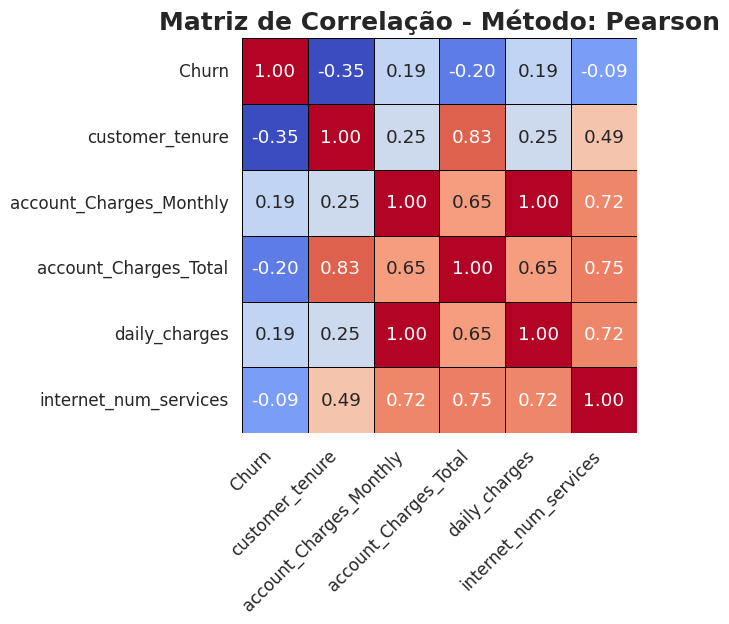

In [644]:
# Plotar a matriz de correlação para Pearson
plot_correlation_matrix(telecom_correlation,
                        num_cols_to_corr,
                        'pearson',
                        plots_dir)

Na análise anterior, observamos que:

- `customer_tenure` teve a correlação mais negativa com churn (≈ –0,35), indicando que clientes mais antigos tendem a permanecer.
- `account_Charges_Monthly` e `daily_charges` apresentaram correlação quase perfeita (≈ 0,999), sinalizando possível redundância.
- `account_Charges_Total` também teve correlação negativa (≈ –0,20), sugerindo que maior gasto acumulado reduz a chance de churn.
- Cobranças mais altas (`monthly` e `daily`) mostraram correlação positiva moderada com churn (≈ 0,19), o que pode refletir impacto na percepção de custo.

Esses insights ajudam a priorizar variáveis e tomar decisões sobre seleção e engenharia de atributos.


### **Associação entre variáveis categóricas**

#### **Teste de Qui-quadrado**

No notebook anterior, utilizamos o **teste qui-quadrado de independência** para verificar a associação estatística entre variáveis categóricas e o churn. Como complemento, aplicamos também o **Cramér’s V**, que quantifica a força dessa associação em uma escala de 0 a 1[^2].

Neste notebook, retomamos brevemente essa abordagem para reforçar a análise das variáveis categóricas mais relevantes.

[^2]: Para a explicação completa dos testes estatísticos utilizados, consulte o notebook anterior: *Desafio Telecom X – Parte 1 (Análise Exploratória)*.


In [645]:
# Loop para calcular o teste de Qui-quadrado para cada coluna categórica
for col in telecom_processed.select_dtypes(include='category').columns:
    ct = pd.crosstab(telecom_processed[col], telecom_processed['Churn'])
    chi2, p, dof, _ = chi2_contingency(ct)
    print(f"{col}: chi2 = {chi2:.2f}, p = {p:.4f}")

Churn: chi2 = 7037.87, p = 0.0000
customer_gender: chi2 = 0.48, p = 0.4866
customer_SeniorCitizen: chi2 = 159.43, p = 0.0000
customer_Partner: chi2 = 158.73, p = 0.0000
customer_Dependents: chi2 = 189.13, p = 0.0000
phone_PhoneService: chi2 = 0.92, p = 0.3388
phone_MultipleLines: chi2 = 11.33, p = 0.0035
internet_InternetService: chi2 = 732.31, p = 0.0000
internet_OnlineSecurity: chi2 = 850.00, p = 0.0000
internet_OnlineBackup: chi2 = 601.81, p = 0.0000
internet_DeviceProtection: chi2 = 558.42, p = 0.0000
internet_TechSupport: chi2 = 828.20, p = 0.0000
internet_StreamingTV: chi2 = 374.20, p = 0.0000
internet_StreamingMovies: chi2 = 375.66, p = 0.0000
account_Contract: chi2 = 1184.60, p = 0.0000
account_PaperlessBilling: chi2 = 258.28, p = 0.0000
account_PaymentMethod: chi2 = 648.14, p = 0.0000


#### **Cramér’s V**

In [646]:
# Loop para calcular Cramér's V para cada coluna categórica
for col in telecom_processed.select_dtypes(include='category').columns:
    ct = pd.crosstab(telecom_processed[col], telecom_processed['Churn'])
    v = association(ct, method='cramer')
    print(f"{col}: Cramér's V = {v:.3f}")

Churn: Cramér's V = 1.000
customer_gender: Cramér's V = 0.009
customer_SeniorCitizen: Cramér's V = 0.151
customer_Partner: Cramér's V = 0.150
customer_Dependents: Cramér's V = 0.164
phone_PhoneService: Cramér's V = 0.012
phone_MultipleLines: Cramér's V = 0.040
internet_InternetService: Cramér's V = 0.322
internet_OnlineSecurity: Cramér's V = 0.347
internet_OnlineBackup: Cramér's V = 0.292
internet_DeviceProtection: Cramér's V = 0.282
internet_TechSupport: Cramér's V = 0.343
internet_StreamingTV: Cramér's V = 0.231
internet_StreamingMovies: Cramér's V = 0.231
account_Contract: Cramér's V = 0.410
account_PaperlessBilling: Cramér's V = 0.192
account_PaymentMethod: Cramér's V = 0.303


Os resultados confirmam que várias variáveis categóricas apresentam associação estatística com o churn, com destaque para características como `account_Contract`, `internet_OnlineSecurity` e `customer_SeniorCitizen`. Essas variáveis mostraram altos valores de qui-quadrado e força de associação moderada a forte (Cramér’s V > 0.3), sugerindo impacto relevante na decisão de cancelamento.

Por outro lado, variáveis como `customer_gender` e `phone_PhoneService` não mostraram associação significativa nem força de relação prática, podendo ser descartadas da modelagem.

A análise combinada dos testes permite focar nas variáveis com maior potencial explicativo e orienta ações mais estratégicas sobre os serviços mais associados ao churn.


### **Mutual Information**

Como complemento aos testes anteriores, também retomamos a análise de **Mutual Information (MI)** entre variáveis categóricas e o churn. Ao contrário do qui-quadrado, que avalia apenas a independência estatística, o MI **mede a quantidade de informação que uma variável fornece sobre outra**, capturando tanto relações lineares quanto não lineares.

Essa métrica é particularmente útil para entender o **poder informativo de cada variável** em relação ao alvo, sendo uma aliada poderosa na seleção de atributos para modelos supervisionados.

Valores mais altos indicam que a variável compartilha mais informação com o churn, sendo mais relevante para fins preditivos.


In [647]:
# Função auxiliar para calcular a informação mútua
def make_mi_scores_classification(
    X: pd.DataFrame,
    y: pd.Series,
    discrete_features: Union[bool, list[str], str] = True,
) -> pd.Series:
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores_series = pd.Series(mi_scores, name= 'MI Scores', index=X.columns)
    return mi_scores_series

In [648]:
telecom_processed.isna().sum()

Churn                         0
customer_gender               0
customer_SeniorCitizen        0
customer_Partner              0
customer_Dependents           0
customer_tenure               0
phone_PhoneService            0
phone_MultipleLines           0
internet_InternetService      0
internet_OnlineSecurity       0
internet_OnlineBackup         0
internet_DeviceProtection     0
internet_TechSupport          0
internet_StreamingTV          0
internet_StreamingMovies      0
account_Contract              0
account_PaperlessBilling      0
account_PaymentMethod         0
account_Charges_Monthly       0
account_Charges_Total        11
daily_charges                 0
internet_num_services         0
dtype: int64

In [649]:
# Separação das features (X) e do target (y)

# Removemos valores ausentes com .dropna()
# Usamos .copy() para evitar alterações no DataFrame original
# Usamos .pop('Churn') para extrair a variável-alvo e removê-la de X
# (o método pop é inplace e retorna pd.Series ao mesmo tempo)

X_mutual = (
    telecom_processed
        .dropna() 
        .copy()
)

y_mutual = X_mutual.pop('Churn')


In [650]:
# Aplica o pd.factorize para as colunas categóricas
for col in X_mutual.select_dtypes(include='category').columns:
    X_mutual[col], _ = pd.factorize(X_mutual[col])

# Verifica se as colunas categóricas foram convertidas corretamente
X_mutual.sample(5)


,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,internet_OnlineSecurity,internet_OnlineBackup,...,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges_Monthly,account_Charges_Total,daily_charges,internet_num_services
3782,0,0,0,0,58,0,1,0,1,1,...,0,0,0,2,1,0,75.80,4415.75,2.53,4
3535,1,0,1,1,10,1,2,0,0,1,...,1,1,0,1,1,0,29.50,255.25,0.98,1
4735,1,0,0,0,69,0,1,1,0,1,...,1,1,0,2,0,2,79.20,5420.65,2.64,1
6953,1,0,1,1,35,0,0,0,0,1,...,1,0,0,1,1,0,55.00,2010.55,1.83,1
4398,0,1,0,1,46,0,1,1,0,1,...,0,0,1,0,1,1,100.25,4753.85,3.34,3


In [651]:
# Cria uma máscara booleana para informar quais variáveis são discretas
discrete_features = X_mutual.dtypes == int

# Usa a função para calcular a informação mútua
mi_scores = make_mi_scores_classification(X_mutual, y_mutual, discrete_features)

# Exibe os scores de informação mútua
mi_scores.sort_values(ascending=False)

account_Contract             0.098182
customer_tenure              0.078950
internet_OnlineSecurity      0.064528
internet_TechSupport         0.062873
internet_InternetService     0.055394
account_Charges_Monthly      0.048710
daily_charges                0.047841
internet_OnlineBackup        0.046659
account_PaymentMethod        0.044423
internet_DeviceProtection    0.043784
account_Charges_Total        0.041990
internet_StreamingMovies     0.031918
internet_StreamingTV         0.031803
internet_num_services        0.028514
account_PaperlessBilling     0.019119
customer_Dependents          0.014270
customer_Partner             0.011383
customer_SeniorCitizen       0.010533
phone_MultipleLines          0.000798
phone_PhoneService           0.000069
customer_gender              0.000037
Name: MI Scores, dtype: float64

In [652]:
def plot_mi_scores(scores, save_path=None):
    scores = scores.sort_values(ascending=True)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    fig.subplots_adjust(top=0.90)
    fig.suptitle('Mutual Information Scores por Feature', fontsize=18, fontweight='bold')
    
    width = np.arange(len(scores))
    ticks = list(scores.index)
    
    bars = ax.barh(width, scores, color='steelblue')
    ax.set_yticks(width)
    ax.set_yticklabels(ticks, fontsize=12)
    
    ax.set_xlabel('Mutual Information Score', fontsize=14)
    ax.set_ylabel('Features', fontsize=14)
    
    sns.despine(ax=ax, left=True, bottom=True)
    ax.tick_params(axis='x', which='both', bottom=False)
    
    max_width = max(bars[i].get_width() for i in range(len(bars)))
    ax.set_xlim(0, max_width * 1.15)
    
    # Anotações com valores MI ao final de cada barra
    for bar in bars:
        width = bar.get_width()
        y = bar.get_y() + bar.get_height() / 2
        ax.annotate(f'{width:.3f}',
                    xy=(width, y),
                    xytext=(5, 0),
                    textcoords='offset points',
                    ha='left',
                    va='center',
                    fontsize=12,
                    fontweight='semibold')
    
    if save_path is not None:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
    
    plt.show()

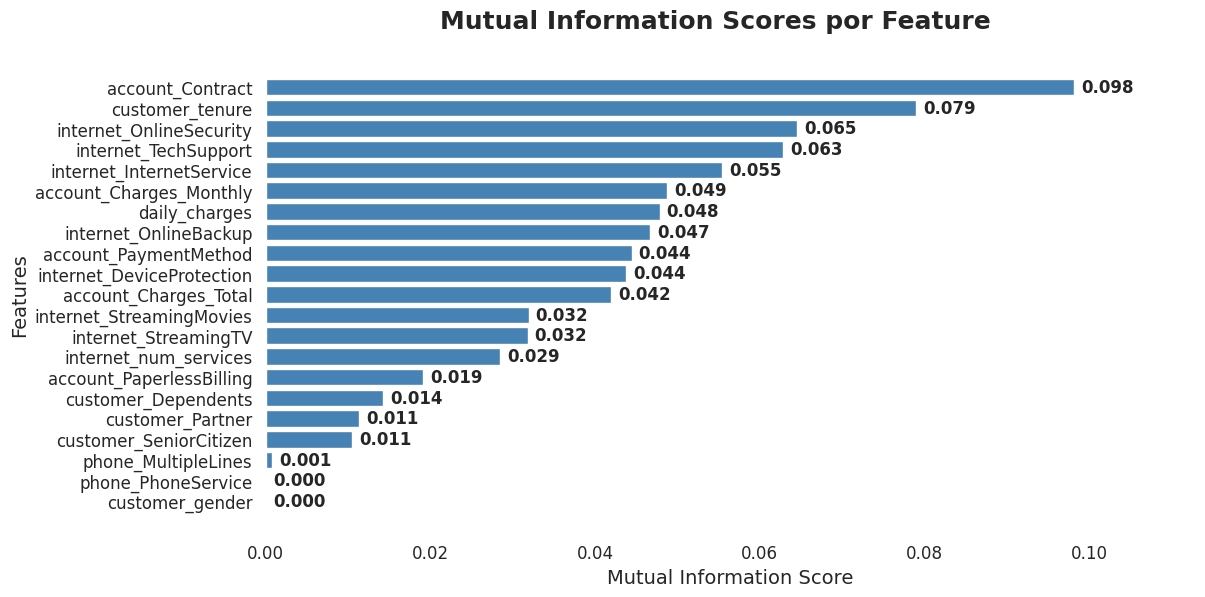

In [653]:
# Plota os scores de informação mútua
plot_mi_scores(mi_scores, save_path=plots_dir / 'mi_scores.png')

Ao analisar os scores de Informação Mútua (MI), observa-se que o **tipo de contrato** (`account_Contract`) é o preditor mais informativo para o churn (MI ≈ 0,098), confirmando as associações fortes indicadas pelo teste qui-quadrado e Cramér’s V.

Variáveis relacionadas ao serviço de internet, como **Online Security**, **Tech Support** e **Internet Service**, também apresentam relevância consistente (MI entre 0,055 e 0,065), reforçando sua importância para a retenção do cliente.

Variáveis financeiras, como **cobrança mensal** (`account_Charges_Monthly`) e **cobrança total** (`account_Charges_Total`), têm scores MI menores (~0,04), indicando contribuição moderada para o entendimento do churn.

Por outro lado, variáveis como **gênero do cliente** (`customer_gender`) e **serviço telefônico** (`phone_PhoneService`), que tiveram pouca associação estatística nos testes anteriores, apresentam valores de MI próximos de zero, sugerindo impacto irrelevante na previsão do churn.

Em resumo, a análise de MI corrobora e complementa os testes clássicos, destacando variáveis chave e validando a consistência dos resultados.


### **Análises direcionadas**

#### **Tempo de Contrato e Total Gasto vs Churn (Evasão)** 

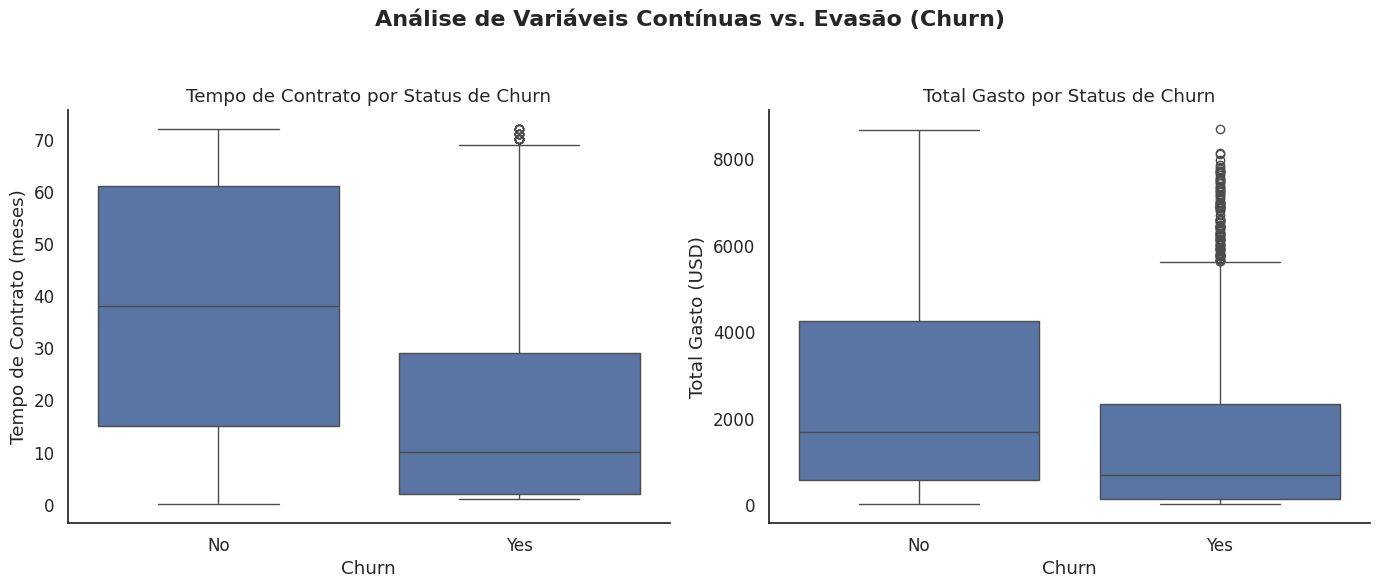

In [654]:
# Cria a figura e os eixos para os boxplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle(
    'Análise de Variáveis Contínuas vs. Evasão (Churn)',
    fontsize=16,
    fontweight='bold'
)

# Tempo de contrato por churn
sns.boxplot(
    data=telecom_processed,
    x='Churn',
    y='customer_tenure',
    ax=axes[0]
)

axes[0].set_title('Tempo de Contrato por Status de Churn')
axes[0].set_xlabel('Churn')
axes[0].set_ylabel('Tempo de Contrato (meses)')

# Total gasto por churn
sns.boxplot(
    data=telecom_processed,
    x='Churn',
    y='account_Charges_Total',
    ax=axes[1]
)
axes[1].set_title('Total Gasto por Status de Churn')
axes[1].set_xlabel('Churn')
axes[1].set_ylabel('Total Gasto (USD)')

sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Salva a figura
plt.savefig(plots_dir / 'continuous_vars_vs_churn.png', bbox_inches='tight')

# Exibe os boxplots
plt.show()


Apesar das análises revelarem variáveis mais ou menos informativas, **nenhuma variável foi removida neste estágio**. Essa decisão permite avaliar o desempenho dos modelos com o conjunto completo de informações disponíveis.

A remoção ou seleção automática de variáveis poderá ser considerada posteriormente com base em:
- Importância de atributos nos modelos (ex: Random Forest, Regressão com regularização)
- Avaliação de desempenho
- Técnicas automáticas de seleção (ex: RFE, SelectKBest, Lasso)

## **Modelagem**

### **Separação features (X) e target (y)**

In [655]:
# Separação das features (X) e do target (y)

# Removemos valores ausentes com .dropna()
# Usamos .copy() para evitar alterações no DataFrame original
# Usamos .pop('Churn') para extrair a variável-alvo e removê-la de X
# (o método pop é inplace e retorna pd.Series ao mesmo tempo)

X = (
    telecom_processed
        #.dropna() 
        .copy()
)

y = X.pop('Churn')


In [656]:
# Carrega o LabelEncoder
le = LabelEncoder()

# Aplica no target
y = le.fit_transform(y)

### **Separando os dados em treino e teste**

Vamos começar separando os dados em conjuntos de treino e teste. O conjunto de treino será utilizado para treinar os modelos, enquanto o conjunto de teste será usado para avaliar o desempenho dos modelos treinados.
Vamos utilizar a função `train_test_split` do scikit-learn para fazer essa separação.
Vamos definir o tamanho do conjunto de teste como 20% dos dados e utilizar uma semente aleatória para garantir a reprodutibilidade dos resultados.
Vamos também garantir que a variável alvo `Churn` esteja balanceada entre os conjuntos de treino e teste, utilizando o parâmetro `stratify` na função `train_test_split`.

In [657]:
# Separando os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3, # 30% dos dados para teste
    random_state=42, # Semente para reprodutibilidade
    stratify=y # Mantém a proporção de classes no split
)

# Exibe as dimensões dos conjuntos de treino e teste
print(f"Dimensões do conjunto de treino: {X_train.shape}, {y_train.shape}")
print(f"Dimensões do conjunto de teste: {X_test.shape}, {y_test.shape}")

Dimensões do conjunto de treino: (4930, 21), (4930,)
Dimensões do conjunto de teste: (2113, 21), (2113,)


### **Seleção de modelos**

#### **Funções auxiliares**

In [658]:
# Função para criar figuras do matplotlib
def _ensure_fig_ax(ax: Optional[plt.Axes],
                   figsize=(8, 6)) -> tuple[plt.Figure, plt.Axes]:
    
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.figure
    return fig, ax

In [659]:
# Função auxiliar para salvar figuras
def _maybe_save(fig: plt.Figure, save_path: Optional[Union[str, Path]]) -> None:
    if save_path:
        path = Path(save_path)
        path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(path, bbox_inches="tight", dpi=300)

In [660]:
# Função para plotar a matriz de confusão a partir de um estimator
def plot_confusion_matrix_from_estimator(
    estimator: ClassifierMixin,
    X,
    y,
    *,
    title: Optional[str] = None,
    cmap: str = "Blues",
    display_labels=None,
    normalize: Optional[str] = None,  # None, 'true', 'pred', 'all'
    save_path: Optional[Union[str, Path]] = None
) -> Tuple[plt.Figure, plt.Axes, ConfusionMatrixDisplay]:
    """
    Plota a matriz de confusão a partir de um estimator, mantendo o estilo
    do plot_confusion_matrix original.
    Retorna (fig, ax, display).
    """
    # Criação da figura
    fig, ax = plt.subplots(figsize=(6, 5))
    fig.subplots_adjust(top=0.88)
    fig.suptitle(
        title or "Matriz de Confusão",
        fontsize=18,
        fontweight='bold'
    )

    # Plot com from_estimator
    disp = ConfusionMatrixDisplay.from_estimator(
        estimator,
        X,
        y,
        display_labels=display_labels,
        cmap=cmap,
        ax=ax,
        normalize=normalize,
        values_format='d' if normalize is None else '.2f',
        colorbar=False  # equivalente ao antigo colorbar=False
    )

    # Estilo visual
    ax.set_xlabel("Predito", fontsize=14)
    ax.set_ylabel("Real", fontsize=14)
    ax.tick_params(axis='both', labelsize=12)

    # Ajustes visuais
    fig.tight_layout()

    # Salvar se necessário
    if save_path:
        path = Path(save_path)
        path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(path, bbox_inches='tight', dpi=300)

    plt.show()

    return fig, ax, disp


In [661]:
# Função para plotar a Precision-Recall a partir de um estimator
def plot_precision_recall_from_estimator(
    estimator: ClassifierMixin,
    X,
    y,
    *,
    ax: Optional[plt.Axes] = None,
    title: Optional[str] = None,
    name: Optional[str] = None,
    color: Optional[str] = None,            
    curve_kwargs: Optional[Dict] = None,
    save_path: Optional[Union[str, Path]] = None
):
    """
    Plota Precision-Recall usando from_estimator.
    Para parâmetros de estilo da curva (cor, linewidth, linestyle, etc.)
    passe-os em curve_kwargs (ex: {'color':'darkorange', 'linewidth':2}).
    """
    fig, ax = _ensure_fig_ax(ax)
    # converte color param para curve_kwargs se necessário
    curve_kwargs = {} if curve_kwargs is None else dict(curve_kwargs)
    if color is not None and 'color' not in curve_kwargs:
        curve_kwargs['color'] = color

    disp = PrecisionRecallDisplay.from_estimator(
        estimator,
        X,
        y,
        name=name,
        ax=ax,
        **curve_kwargs
    )

    ax.set_title(title or "Curva Precision-Recall", fontsize=14, fontweight="bold")
    ax.set_xlabel("Recall", fontsize=12)
    ax.set_ylabel("Precision", fontsize=12)
    ax.grid(True)
    ax.legend(loc="best")

    _maybe_save(fig, save_path)


    return fig, ax, disp

In [662]:
# Função para plotar a curva ROC a partir de um estimator
def plot_roc_from_estimator(
    estimator: ClassifierMixin,
    X,
    y,
    *,
    ax: Optional[plt.Axes] = None,
    title: Optional[str] = None,
    name: Optional[str] = None,
    color: Optional[str] = None,
    curve_kwargs: Optional[Dict] = None,
    plot_chance_level: bool = True,
    save_path: Optional[Union[str, Path]] = None
):
    fig, ax = _ensure_fig_ax(ax)
        
    curve_kwargs = {} if curve_kwargs is None else dict(curve_kwargs)
    if color is not None and 'color' not in curve_kwargs:
        curve_kwargs['color'] = color

    disp = RocCurveDisplay.from_estimator(
        estimator,
        X,
        y,
        name=name,
        ax=ax,
        curve_kwargs=curve_kwargs,
        plot_chance_level=plot_chance_level
    )

    ax.set_title(title or "Curva ROC", fontsize=14, fontweight="bold")
    ax.set_xlabel("False Positive Rate", fontsize=12)
    ax.set_ylabel("True Positive Rate", fontsize=12)
    ax.grid(True)
    ax.legend(loc="best")

    _maybe_save(fig, save_path)



    return fig, ax, disp

#### **Pipeline de Pré-processamento**


In [663]:
# Lista com as variáveis numéricas e categóricas
numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(include='category').columns.tolist()

# Exibe as variáveis numéricas e categóricas
print("Variáveis Numéricas:", numeric_features)
print("Variáveis Categóricas:", categorical_features)

Variáveis Numéricas: ['customer_tenure', 'account_Charges_Monthly', 'account_Charges_Total', 'daily_charges', 'internet_num_services']
Variáveis Categóricas: ['customer_gender', 'customer_SeniorCitizen', 'customer_Partner', 'customer_Dependents', 'phone_PhoneService', 'phone_MultipleLines', 'internet_InternetService', 'internet_OnlineSecurity', 'internet_OnlineBackup', 'internet_DeviceProtection', 'internet_TechSupport', 'internet_StreamingTV', 'internet_StreamingMovies', 'account_Contract', 'account_PaperlessBilling', 'account_PaymentMethod']


In [664]:
# Imputer numérico
numeric_imputer = SimpleImputer(strategy='median')

# Scaler
scaler = RobustScaler()  # ou StandardScaler(), RobustScaler(), etc.

# Pipeline para variáveis numéricas
numeric_pipeline = Pipeline(steps=[
    ('imputer', numeric_imputer),
    ('scaler', scaler)
])

# Encoder categórico
categorical_encoder = OneHotEncoder(
    handle_unknown='ignore', # Ignora categorias desconhecidas
    # Para o caso de variáveis binárias
    # remove uma categoria para evitar multicolinearidade
    drop='if_binary' 
)

# Pipeline para variáveis categóricas
categorical_pipeline = Pipeline(steps=[
    ('encoder', categorical_encoder)
])

# ColumnTransformer para aplicar os pipelines
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
], remainder='drop')  # Descarta colunas não especificadas

# Estrategia de validação cruzada
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lista de métricas para avaliação
scoring_metrics = [
    # Métricas de acurácia e balanceamento
    "balanced_accuracy",
    
    # Métricas de classificação binária
    "precision",
    "recall",
    "f1",
    
    # Métrica ponderada para desbalanceamento
    "f1_weighted",
    
    # Métrica de área sob a curva ROC
    "roc_auc"
]

preprocessor

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


#### **Modelo Baseline (DummyClassifier)**

Para estabelecer uma linha de base de desempenho, utilizamos o `DummyClassifier` do scikit-learn. Este modelo não realiza aprendizado real: ele gera previsões com base em estratégias simples, como sempre prever a classe majoritária ou distribuir as previsões aleatoriamente.

Seu principal objetivo é fornecer uma **referência mínima** de desempenho, permitindo avaliar se os modelos mais complexos realmente estão agregando valor à tarefa de previsão.

---

**Estratégias disponíveis (`strategy`):**

- **"most_frequent"**: sempre prevê a classe mais frequente do conjunto de treino.
- **"prior"** *(padrão)*: comportamento idêntico ao `"most_frequent"` no `predict()`, mas o `predict_proba()` retorna a distribuição empírica das classes.
- **"stratified"**: gera previsões aleatórias, respeitando a distribuição real das classes.
- **"uniform"**: prevê cada classe com probabilidade igual, independentemente da distribuição real.
- **"constant"**: sempre retorna uma única classe definida manualmente pelo usuário.

---

Neste projeto, o uso do `DummyClassifier` nos permite responder: **um modelo mais sofisticado é realmente melhor do que simplesmente prever a classe mais comum?**

Como esse modelo não usa as variáveis de entrada, não há necessidade de pré-processamento ou uso de pipeline. Ele pode ser aplicado diretamente aos dados de treino e teste.

In [665]:
# Treina o DummyClassifier com a estratégia 'prior'
dummy_classifier = DummyClassifier(strategy='prior', random_state=42)
dummy_classifier.fit(X_train, y_train)

# Predição
y_pred_dummy = dummy_classifier.predict(X_test)

# Avaliação do modelo DummyClassifier
classification_report_dummy = classification_report(
    y_test,
    y_pred_dummy,
    target_names=['No', 'Yes'],
    zero_division=0  # Evita divisão por zero em métricas de precisão e recall
)

# Exibe o relatório de classificação
print("Relatório de Classificação - DummyClassifier:")
print(classification_report_dummy)

Relatório de Classificação - DummyClassifier:
              precision    recall  f1-score   support

          No       0.73      1.00      0.85      1552
         Yes       0.00      0.00      0.00       561

    accuracy                           0.73      2113
   macro avg       0.37      0.50      0.42      2113
weighted avg       0.54      0.73      0.62      2113



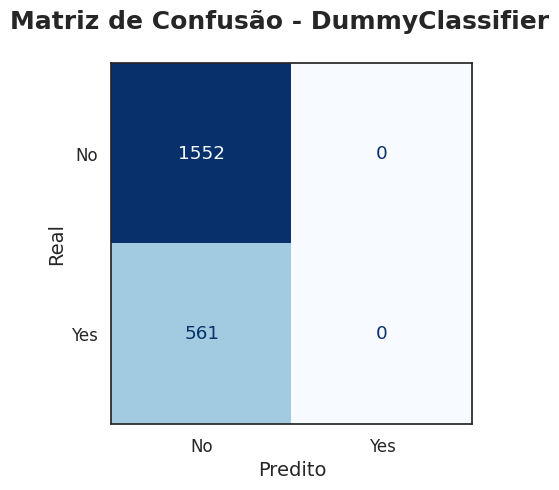

In [666]:
# Chamada da função
plot_confusion_matrix_from_estimator(
    dummy_classifier,
    X_test,
    y_test,
    title="Matriz de Confusão - DummyClassifier",
    display_labels=['No', 'Yes'],
    save_path=plots_dir / 'dummy_classifier_confusion_matrix.png'
)

plt.show()

#### **Modelo de Regressão Logística**

Agora vamos usar o modelo de Regressão Logística, que é amplamente utilizado para problemas de classificação binária, como o nosso caso de prever churn (sim ou não). Esse modelo assume uma relação linear entre as variáveis independentes e a probabilidade do evento, e por isso geralmente se beneficia da normalização dos dados para que as variáveis tenham escala semelhante, evitando que alguma variável com valores muito altos ou baixos domine o ajuste do modelo.

In [667]:
# Carrega o modelo de Regressão Logística
logistic_model = LogisticRegression(
    class_weight='balanced', # Ajusta pesos para lidar com desbalanceamento
)

# Pipeline de pré-processamento e modelo
logistic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', logistic_model)
])

# Exibe o pipeline
logistic_pipeline

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [668]:
# Validação cruzada
cv_results_logistic = cross_validate(
    logistic_pipeline,
    X_train,
    y_train,
    cv=cv_strategy,
    scoring= scoring_metrics,
    return_train_score=True
)

# Exibe os resultados da validação cruzada (tanto treino quanto teste)
# para avaliar overfitting
cv_results_df_logistic = pd.DataFrame(cv_results_logistic)
print("\nResultados da Validação Cruzada - Regressão Logística:")
print(cv_results_df_logistic.mean())



Resultados da Validação Cruzada - Regressão Logística:
fit_time                   0.325731
score_time                 0.152753
test_balanced_accuracy     0.766629
train_balanced_accuracy    0.772351
test_precision             0.520296
train_precision            0.525011
test_recall                0.799687
train_recall               0.809058
test_f1                    0.630363
train_f1                   0.636784
test_f1_weighted           0.764088
train_f1_weighted          0.767933
test_roc_auc               0.845813
train_roc_auc              0.851256
dtype: float64


In [669]:
# Treina o modelo de Regressão Logística
logistic_pipeline.fit(X_train, y_train)

# Predição
y_pred_logistic = logistic_pipeline.predict(X_test)

# Avaliação do modelo de Regressão Logística
classification_report_logistic = classification_report(
    y_test,
    y_pred_logistic,
    target_names=['No', 'Yes'],
    zero_division=0  # Evita divisão por zero em métricas de precisão e recall
)
# Exibe o relatório de classificação
print("Relatório de Classificação - Regressão Logística:")
print(classification_report_logistic)

Relatório de Classificação - Regressão Logística:
              precision    recall  f1-score   support

          No       0.91      0.71      0.80      1552
         Yes       0.50      0.80      0.62       561

    accuracy                           0.73      2113
   macro avg       0.70      0.76      0.71      2113
weighted avg       0.80      0.73      0.75      2113



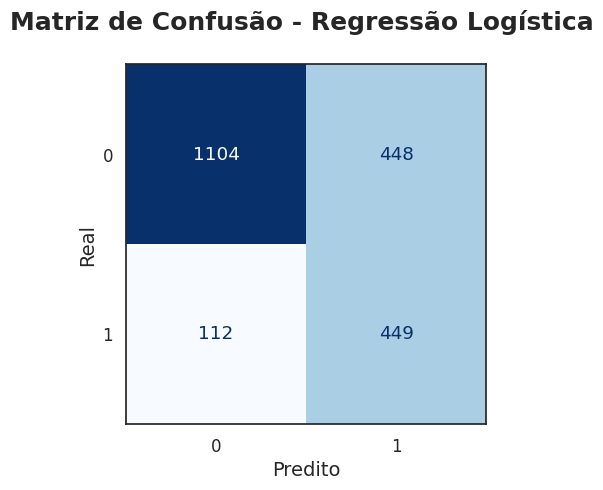

In [670]:
# Plota a matriz de confusão do modelo de Regressão Logística
plot_confusion_matrix_from_estimator(
    estimator=logistic_pipeline,
    X=X_test,
    y=y_test,
    title='Matriz de Confusão - Regressão Logística',
    save_path=plots_dir / 'conf_matrix_logistic.png'
)

# Exibe
plt.show()

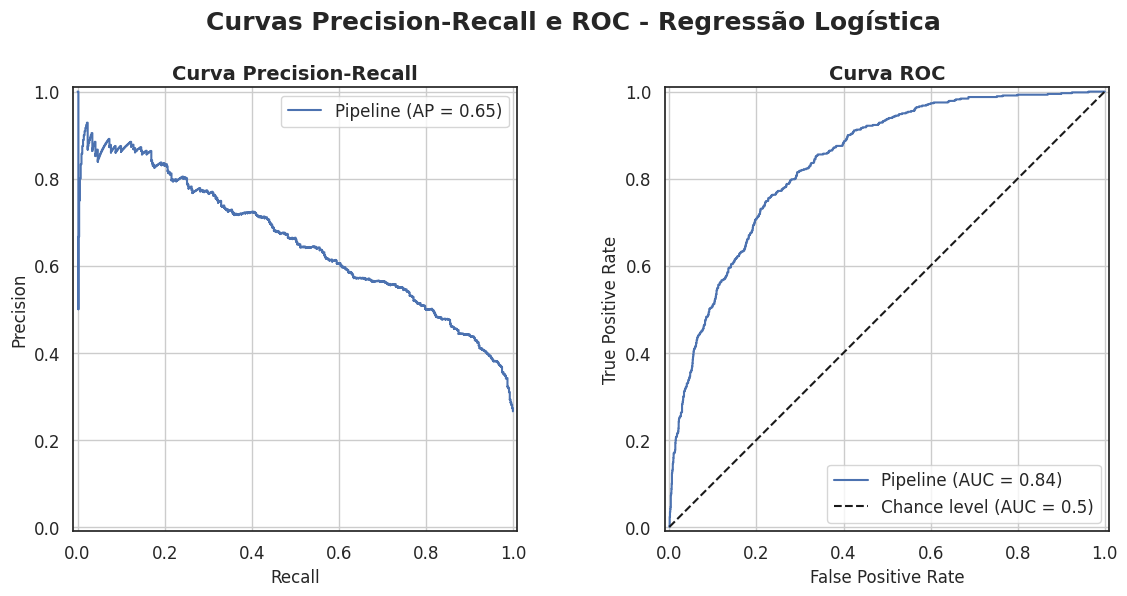

In [671]:
# Plota as curvas Precision-Recall e ROC
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
fig.subplots_adjust(top=0.85)
fig.suptitle(
            'Curvas Precision-Recall e ROC - Regressão Logística',
            fontsize=18,
            fontweight='bold'
            )

# Plota a curva Precision-Recall
plot_precision_recall_from_estimator(
    estimator=logistic_pipeline,
    X=X_test,
    y=y_test,
    ax=ax[0],
    title='Curva Precision-Recall'
)

# Plota a curva ROC
plot_roc_from_estimator(
    estimator=logistic_pipeline,
    X=X_test,
    y=y_test,
    ax=ax[1],
    title='Curva ROC'
)

# Exibe as curvas
plt.show()

A regressão logística apresentou um desempenho equilibrado entre treino e teste, com pequena diferença entre balanced accuracy, indicando boa generalização. O recall para a classe positiva (clientes que deram churn) foi alto (~0.81), o que é importante para detectar churners. Porém, a precisão para essa classe é baixa (~0.51), sugerindo que o modelo gera muitos falsos positivos. Isso pode impactar o custo se ações forem tomadas indevidamente. O F1-score (0.63) mostra um equilíbrio moderado entre precisão e recall. O AUC ROC (0.85) indica boa capacidade geral de separação entre classes.

#### **Modelo de Decision Tree**

A Árvore de Decisão foi escolhida por sua capacidade de lidar com dados heterogêneos e variáveis em diferentes escalas sem a necessidade de normalização. Esse modelo é fácil de interpretar, pois representa as decisões em uma estrutura hierárquica de regras simples, o que facilita a compreensão dos fatores que levam à evasão dos clientes. Além disso, a Árvore de Decisão consegue capturar relações não lineares e interações complexas entre as variáveis, o que pode melhorar o desempenho em problemas reais, onde a relação entre os atributos e o resultado pode ser mais complexa.

In [672]:
# Carrega o modelo
decision_tree_model = DecisionTreeClassifier(
    criterion='gini',  # Critério de divisão
    max_depth=5,  # Profundidade máxima da árvore
    class_weight='balanced',  # Ajusta pesos para lidar com desbalanceamento
    random_state=42  # Semente para reprodutibilidade
)

# Pipeline de pré-processamento e modelo
decision_tree_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', decision_tree_model)
])

# Exibe o pipeline
decision_tree_pipeline

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [673]:
# Validação cruzada
cv_results_tree = cross_validate(
    decision_tree_pipeline,
    X_train,
    y_train,
    cv=cv_strategy,
    scoring=scoring_metrics,
    return_train_score=True
)

# Exibe os resultados da validação cruzada (tanto treino quanto teste)
# para avaliar overfitting
cv_results_df_tree = pd.DataFrame(cv_results_tree)
print("\nResultados da Validação Cruzada - Decision Tree:")
print(cv_results_df_tree.mean())


Resultados da Validação Cruzada - Decision Tree:
fit_time                   0.156121
score_time                 0.113119
test_balanced_accuracy     0.753398
train_balanced_accuracy    0.780926
test_precision             0.512883
train_precision            0.540141
test_recall                0.772127
train_recall               0.812125
test_f1                    0.616016
train_f1                   0.648430
test_f1_weighted           0.757482
train_f1_weighted          0.778040
test_roc_auc               0.824982
train_roc_auc              0.857713
dtype: float64


In [674]:
# Treina o modelo de Decision Tree
decision_tree_pipeline.fit(X_train, y_train)

# Predição
y_pred_decision_tree = decision_tree_pipeline.predict(X_test)

# Avaliação do modelo de Decision Tree
classification_report_decision_tree = classification_report(
    y_test,
    y_pred_decision_tree,
    target_names=['No', 'Yes'],
    zero_division=0  # Evita divisão por zero em métricas de precisão e recall
)

# Exibe o relatório de classificação
print("Relatório de Classificação - Decision Tree:")
print(classification_report_decision_tree)

Relatório de Classificação - Decision Tree:
              precision    recall  f1-score   support

          No       0.90      0.73      0.81      1552
         Yes       0.51      0.78      0.62       561

    accuracy                           0.74      2113
   macro avg       0.71      0.75      0.71      2113
weighted avg       0.80      0.74      0.76      2113



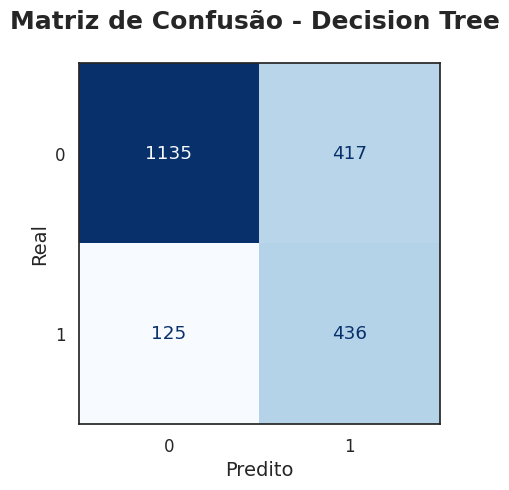

In [675]:
# Plota a matriz de confusão do modelo de Decision Tree
plot_confusion_matrix_from_estimator(
    estimator=decision_tree_pipeline,
    X=X_test,
    y=y_test,
    title='Matriz de Confusão - Decision Tree',
    save_path=plots_dir / 'conf_matrix_decision_tree.png'
)

# Exibe
plt.show()

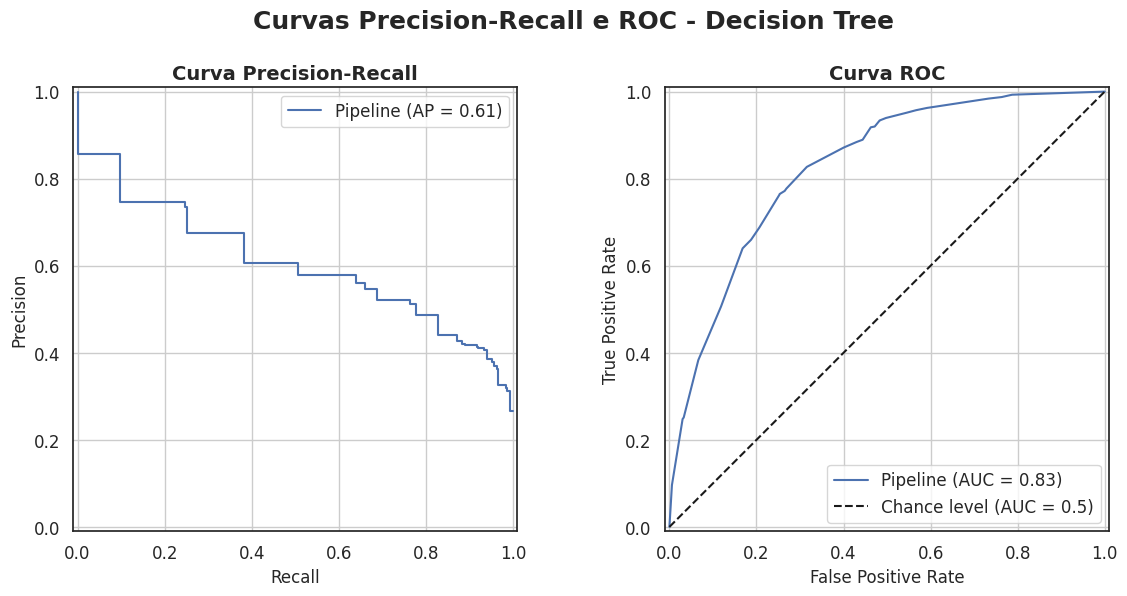

In [676]:
# Plota as curvas Precision-Recall e ROC
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
fig.subplots_adjust(top=0.85)
fig.suptitle(
            'Curvas Precision-Recall e ROC - Decision Tree',
            fontsize=18,
            fontweight='bold'
            )

# Plota a curva Precision-Recall
plot_precision_recall_from_estimator(
    estimator=decision_tree_pipeline,
    X=X_test,
    y=y_test,
    ax=ax[0],
    title='Curva Precision-Recall',
    save_path=plots_dir / 'precision_recall_decision_tree.png'
)

# Plota a curva ROC
plot_roc_from_estimator(
    estimator=decision_tree_pipeline,
    X=X_test,
    y=y_test,
    ax=ax[1],
    title='Curva ROC',
    save_path=plots_dir / 'roc_decision_tree.png'
)

# Exibe as curvas
plt.show()

A árvore de decisão tem desempenho semelhante, com uma leve queda no balanced accuracy (0.75 teste vs 0.78 treino), uma diferença muito baixa. O recall da classe positiva caiu um pouco para 0.77, mas a precisão também é baixa (~0.51), mantendo o mesmo problema de falsos positivos. O F1-score também é inferior ao da regressão logística, e o AUC ROC está menor (0.82). Portanto, apesar da árvore ser rápida e interpretável, seu desempenho geral é inferior.

#### **Modelo de Random Forest**

O modelo Random Forest foi selecionado por ser um método robusto de ensemble que combina múltiplas árvores de decisão para melhorar a precisão e reduzir o risco de overfitting. Ele é capaz de lidar com dados não lineares e não requer normalização. Além disso, o Random Forest oferece maior estabilidade e generalização ao agregar previsões de diversas árvores, tornando-o uma ótima opção para problemas complexos como a previsão de evasão de clientes.

In [677]:
# Carrega o modelo de Random Forest
rf_model = RandomForestClassifier(
    criterion='gini', # Critério de qualidade da divisão
    max_depth= 5, # Profundidade máxima das árvores (evita overfitting)
    n_estimators=100, # Número de árvores na floresta
    class_weight='balanced', # Ajusta pesos para lidar com desbalanceamento
    random_state=42, # Semente para reprodutibilidade
    oob_score=True
)

# Pipeline de pré-processamento e modelo
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf_model)
])

# Exibe o pipeline
rf_pipeline

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [678]:
# Validação cruzada
cv_results_rf = cross_validate(
    rf_pipeline,
    X_train,
    y_train,
    cv=cv_strategy,
    scoring= scoring_metrics,
    return_train_score=True
)

# Exibe os resultados da validação cruzada (tanto treino quanto teste)
# para avaliar overfitting
cv_results_df_rf = pd.DataFrame(cv_results_rf)
print("\nResultados da Validação Cruzada - Random Forest:")
print(cv_results_df_rf.mean())


Resultados da Validação Cruzada - Random Forest:
fit_time                   1.155169
score_time                 0.149559
test_balanced_accuracy     0.762627
train_balanced_accuracy    0.782968
test_precision             0.514865
train_precision            0.534514
test_recall                0.796648
train_recall               0.825876
test_f1                    0.625360
train_f1                   0.648879
test_f1_weighted           0.759963
train_f1_weighted          0.775264
test_roc_auc               0.843614
train_roc_auc              0.864782
dtype: float64


In [679]:
# Treina o modelo de Random Forest
rf_pipeline.fit(X_train, y_train)

# Predição
y_pred_rf = rf_pipeline.predict(X_test)

# Avaliação do modelo de Random Forest
classification_report_rf = classification_report(
    y_test,
    y_pred_rf,
    target_names=['No', 'Yes'],
    zero_division=0  # Evita divisão por zero em métricas de precisão e recall
)
print("Relatório de Classificação - Random Forest:")
print(classification_report_rf)

Relatório de Classificação - Random Forest:
              precision    recall  f1-score   support

          No       0.91      0.72      0.80      1552
         Yes       0.50      0.80      0.62       561

    accuracy                           0.74      2113
   macro avg       0.71      0.76      0.71      2113
weighted avg       0.80      0.74      0.75      2113



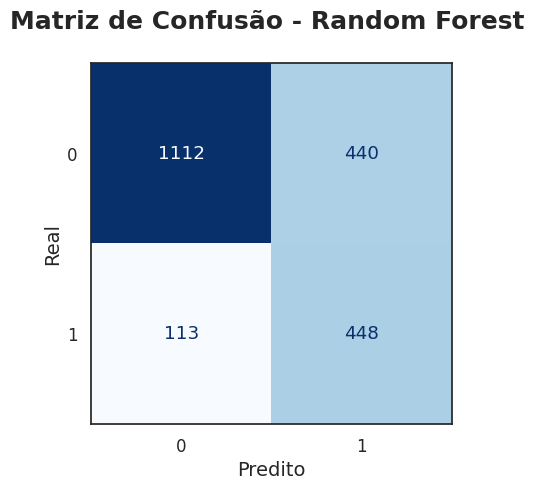

In [680]:
# Matriz de confusão do modelo de Random Forest
plot_confusion_matrix_from_estimator(
    estimator=rf_pipeline,
    X=X_test,
    y=y_test,
    title='Matriz de Confusão - Random Forest',
    save_path=plots_dir / 'conf_matrix_random_forest.png'
)

# Exibe
plt.show()

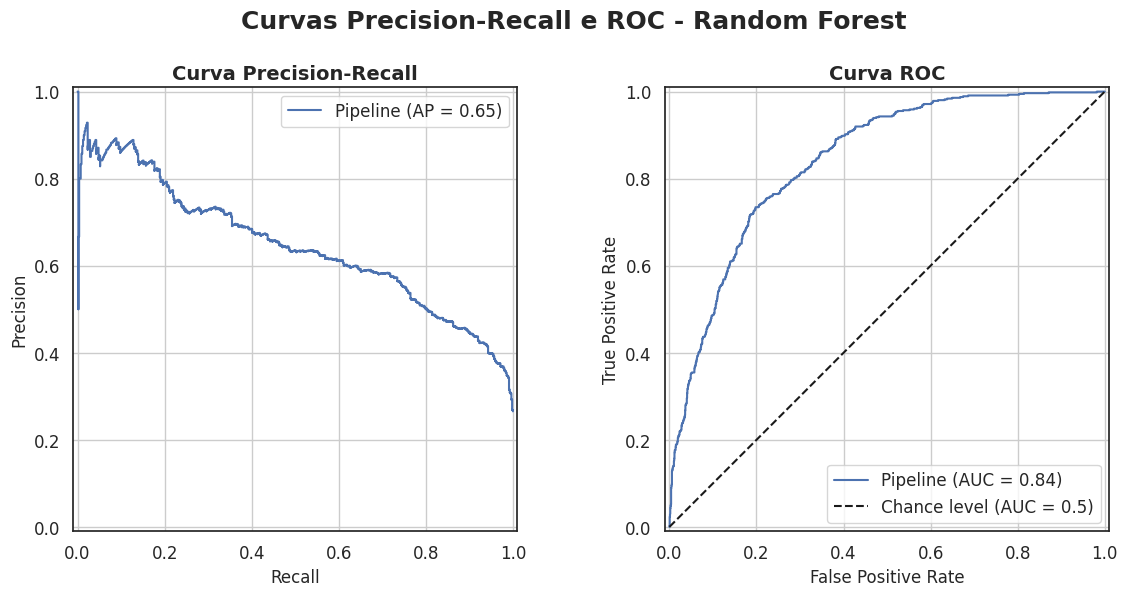

In [681]:
# Plota as curvas Precision-Recall e ROC
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
fig.subplots_adjust(top=0.85)
fig.suptitle(
            'Curvas Precision-Recall e ROC - Random Forest',
            fontsize=18,
            fontweight='bold'
            )

# Plota a curva Precision-Recall
plot_precision_recall_from_estimator(
    estimator=rf_pipeline,
    X=X_test,
    y=y_test,
    ax=ax[0],
    title='Curva Precision-Recall'
)

# Plota a curva ROC
plot_roc_from_estimator(
    estimator=rf_pipeline,
    X=X_test,
    y=y_test,
    ax=ax[1],
    title='Curva ROC'
)

# Salva a figura
plt.savefig(plots_dir / 'precision_recall_roc_rf.png', bbox_inches='tight')

# Exibe as curvas
plt.show()

A Random Forest se destacou por um desempenho robusto, com balanced accuracy próxima à regressão logística (0.76 teste vs 0.78 treino), uma diferença muito pequena. O recall para churners é alto (0.79), e a precisão (0.52) é levemente melhor que nos outros modelos, o que reduz falsos positivos. O F1-score (0.63) e o AUC ROC (0.85) são similares à regressão logística, mas com ligeira vantagem para Random Forest em recall, essencial para captar clientes que podem cancelar. O tempo de treino é maior, mas o ganho em recall pode justificar.

### **Avaliação dos modelos**

No meu problema de churn, a classe positiva (os clientes que cancelam) é minoritária, e o que importa mesmo é identificar o máximo possível desses clientes, ou seja, minimizar os falsos negativos. Por isso, meu foco principal tem que ser no **recall** da classe positiva, que mede a sensibilidade do modelo.

- Um **recall alto** significa que estou conseguindo captar a maioria dos churners, evitando que muitos escapem.

- Ao mesmo tempo, preciso de uma **precisão moderada** para não gerar muitos falsos alarmes, porque isso pode custar caro se eu agir em clientes que não vão cancelar.

- O **F1-score** ajuda a equilibrar esses dois aspectos, então é uma métrica muito útil para avaliar o modelo.

O **AUC ROC** é bom para medir a capacidade geral do modelo separar as classes, mas ele pode ser menos sensível ao problema do desbalanceamento das classes que eu tenho aqui. Se eu quiser dar ainda mais atenção aos churners, posso considerar o **AUC PR** (Precision-Recall), que foca mais na performance da classe positiva.

**Minha recomendação:**

- Priorizar modelos que tenham recall alto para a classe positiva e um bom F1-score.

- Pelos resultados que obtive, o **Random Forest** e a **Regressão Logística** são os melhores candidatos até agora.

- Se eu quiser reduzir os custos com falsos positivos, vou tentar melhorar a precisão, seja com engenharia de features ou ajustando o threshold de decisão do modelo.

- Sempre usar validação cruzada e métricas que considerem o desbalanceamento para fazer esses ajustes.


## **Interpretação dos modelos**

Para entender melhor como meus modelos tomam decisões, vou seguir uma sequência de métodos interpretativos que vão do geral para o específico:

- **Permutation Importance:**  
  Essa técnica mede a importância das variáveis ao observar o impacto na performance do modelo quando os valores de uma feature são embaralhados. É uma forma model-agnóstica de entender quais features são mais relevantes para a predição.

- **Partial Dependence Plots (PDPs):**  
  Os PDPs mostram a relação marginal entre uma feature e a predição do modelo, ajudando a visualizar como mudanças naquela variável influenciam a resposta prevista, mantendo as outras features constantes.

- **SHAP (SHapley Additive exPlanations):**  
  O SHAP fornece explicações detalhadas no nível individual, mostrando a contribuição de cada feature para a predição de cada exemplo. Isso é ótimo para entender decisões específicas do modelo e justificar resultados.

Essa abordagem me permite primeiro identificar as variáveis mais importantes de forma global, depois entender os efeitos das variáveis individualmente, e por fim analisar previsões específicas com maior detalhe.

### **Permutation Importance**

#### **Regressão Logística**

In [682]:
logistic_perm = PermutationImportance(
    logistic_pipeline,
    random_state=42
).fit(X_test, y_test)

# Exibe os pesos das features
show_weights(
    logistic_perm,
    feature_names=X_test.columns.tolist(),
)

Weight,Feature
0.0840 ± 0.0198,customer_tenure
0.0175 ± 0.0067,internet_InternetService
0.0149 ± 0.0079,account_Charges_Total
0.0019 ± 0.0020,customer_SeniorCitizen
0.0003 ± 0.0039,account_PaperlessBilling
-0.0003 ± 0.0056,account_PaymentMethod
-0.0004 ± 0.0048,phone_MultipleLines
-0.0009 ± 0.0067,account_Charges_Monthly
-0.0012 ± 0.0064,internet_StreamingMovies
-0.0014 ± 0.0025,customer_gender


#### **Decision Tree**

In [ ]:
decision_tree_perm = PermutationImportance(
    decision_tree_pipeline,
    random_state=42
).fit(X_test, y_test)

# Exibe os pesos das features
show_weights(
    decision_tree_perm,
    feature_names=X_test.columns.tolist(),
)


Weight,Feature
0.0412 ± 0.0089,internet_InternetService
0.0285 ± 0.0140,account_Contract
0.0140 ± 0.0018,account_Charges_Total
0.0090 ± 0.0029,account_Charges_Monthly
0.0059 ± 0.0013,daily_charges
0.0027 ± 0.0092,customer_tenure
0 ± 0.0000,customer_Partner
0 ± 0.0000,customer_gender
0 ± 0.0000,account_PaperlessBilling
0 ± 0.0000,internet_StreamingTV


#### **Random Forest**

In [683]:
rf_perm = PermutationImportance(
    rf_pipeline,
    random_state=42
).fit(X_test, y_test)

# Exibe os pesos das features
show_weights(
    rf_perm,
    feature_names=X_test.columns.tolist(),
)


Weight,Feature
0.0150 ± 0.0072,account_Contract
0.0028 ± 0.0041,internet_InternetService
0.0022 ± 0.0018,account_PaperlessBilling
0.0022 ± 0.0041,internet_OnlineSecurity
0.0012 ± 0.0013,customer_SeniorCitizen
0.0010 ± 0.0011,customer_gender
0.0006 ± 0.0016,internet_num_services
0.0006 ± 0.0025,daily_charges
0.0002 ± 0.0019,internet_DeviceProtection
0.0001 ± 0.0068,account_Charges_Total


<a id="ref1"></a>
**[1]** A explicação detalhada sobre correlação, incluindo fórmulas, pode ser consultada no notebook anterior: *Desafio Telecom X – Parte 1 (Análise Exploratória)*.